In [1]:
import warnings
from warnings import simplefilter
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
warnings.filterwarnings("ignore")
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

### Data Pre-processing

In [2]:
from itertools import combinations
import gc
def data_preprocessing(df):
    cols = [c for c in df.columns if c not in ['row_id', 'time_id']]
    df = df[cols]

    prices = ['reference_price','far_price', 'near_price', 'ask_price', 'bid_price', 'wap']

    for c in combinations(prices, 2):
        df[f'{c[0]}_minus_{c[1]}'] = (df[f'{c[0]}'] - df[f'{c[1]}']).astype(np.float32)
        df[f'{c[0]}_times_{c[1]}'] = (df[f'{c[0]}'] * df[f'{c[1]}']).astype(np.float32)
        df[f'{c[0]}_{c[1]}_imb'] = df.eval(f'({c[0]}-{c[1]})/({c[0]}+{c[1]})')

    for c in combinations(prices, 3):
        max_ = df[list(c)].max(axis=1)
        min_ = df[list(c)].min(axis=1)
        mid_ = df[list(c)].sum(axis=1)-min_-max_
        df[f'{c[0]}_{c[1]}_{c[2]}_imb2'] = (max_-mid_)/(mid_-min_)

    df.drop(columns=['date_id'], inplace=True)
    gc.collect()
    return df

def data_split_day(df:pd.DataFrame, _min, _max):
    df = df[df['date_id'] < _max]
    df = df[df['date_id'] >= _min]
    return df

def data_split_xy_and_data_preprocess(df:pd.DataFrame):
    x = df.drop(['target'],axis=1)
    x = data_preprocessing(x)
    y = df[['target']]
    return x, y


### LGBMRegressor

In [3]:
from lightgbm import LGBMRegressor
def trainLGBM(df_train_x, df_train_y, df_valid_x, df_valid_y):
    lgb_params = {
            "objective": "mae",
            "n_estimators": 500,
            "num_leaves": 256,
            "subsample": 0.6,
            "colsample_bytree": 0.8,
            "learning_rate": 0.1,
            'max_depth': 40,
            "n_jobs": 8,
            "device": "cpu",
            "verbosity": -1,
            "importance_type": "gain",
            "reg_alpha": 0.2,
            "reg_lambda": 3.25
        }
    LGBM=LGBMRegressor(**lgb_params)
    LGBM.fit(
                df_train_x, df_train_y,
                eval_set=[(df_valid_x, df_valid_y)],
                callbacks=[
                    lgb.callback.early_stopping(stopping_rounds=100),
                ],
            )
    return LGBM

### Evaluation

In [4]:
# Read the dataset from a CSV file using Pandas
df = pd.read_csv("train.csv")
df = df.dropna(subset=['target'])


def data_split(df_train, df_valid, df_tests):
    df_train_x, df_train_y = data_split_xy_and_data_preprocess(df_train)
    df_valid_x, df_valid_y = data_split_xy_and_data_preprocess(df_valid)
    df_tests_x, df_tests_y = data_split_xy_and_data_preprocess(df_tests)
    return df_train_x, df_train_y, df_valid_x, df_valid_y, df_tests_x, df_tests_y

def evaluate(model, trainX, trainY, validX, validY, testX, testY, txt):
    if isinstance(trainX, pd.DataFrame):
        pred_LGB = model.predict(trainX)
        print(f"{txt} | Train Loss : ", mean_absolute_error(trainY, pred_LGB))
    if isinstance(validX, pd.DataFrame):
        pred_LGB = model.predict(validX)
        print(f"{txt} | Valid Loss : ", mean_absolute_error(validY, pred_LGB))
    if isinstance(testX, pd.DataFrame):
        pred_LGB = model.predict(testX)
        print(f"{txt} | Tests Loss : ", mean_absolute_error(testY, pred_LGB))


In [5]:
# Get Two Stock
df_084 = df[df['stock_id'] == 84]
df_175 = df[df['stock_id'] == 175]
df_cat = pd.concat([df_084, df_175], axis=0)
df_all = df

df_all_train, df_all_valid, df_all_tests = data_split_day(df_all, 0, 399), data_split_day(df_all, 400, 478), data_split_day(df_all, 478, 481)
df_084_train, df_084_valid, df_084_tests = data_split_day(df_084, 0, 399), data_split_day(df_084, 400, 478), data_split_day(df_084, 478, 481)
df_175_train, df_175_valid, df_175_tests = data_split_day(df_175, 0, 399), data_split_day(df_175, 400, 478), data_split_day(df_175, 478, 481)
df_cat_train, df_cat_valid, df_cat_tests = data_split_day(df_cat, 0, 399), data_split_day(df_cat, 400, 478), data_split_day(df_cat, 478, 481)

trainX_all, trainY_all, validX_all, validY_all, testX_all, testY_all = data_split(df_all_train, df_all_valid, df_all_tests)
trainX_084, trainY_084, validX_084, validY_084, testX_084, testY_084 = data_split(df_084_train, df_084_valid, df_084_tests)
trainX_175, trainY_175, validX_175, validY_175, testX_175, testY_175 = data_split(df_175_train, df_175_valid, df_175_tests)
trainX_cat, trainY_cat, validX_cat, validY_cat, testX_cat, testY_cat = data_split(df_cat_train, df_cat_valid, df_cat_tests)


model_all = trainLGBM(trainX_all, trainY_all, validX_all, validY_all)
model_084 = trainLGBM(trainX_084, trainY_084, validX_084, validY_084)
model_175 = trainLGBM(trainX_175, trainY_175, validX_175, validY_175)
model_cat = trainLGBM(trainX_cat, trainY_cat, validX_cat, validY_cat)

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[62]	valid_0's l1: 5.91638
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 3.89163
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3]	valid_0's l1: 3.99917
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 3.94599


In [6]:
evaluate(model_all, None, None, None, None, testX_084, testY_084, "Model DataSet : stock_All | Evaluate DataSet : stock_084")
evaluate(model_all, None, None, None, None, testX_175, testY_175, "Model DataSet : stock_All | Evaluate DataSet : stock_175")
evaluate(model_all, None, None, None, None, testX_cat, testY_cat, "Model DataSet : stock_All | Evaluate DataSet : stock_cat")
evaluate(model_084, None, None, None, None, testX_084, testY_084, "Model DataSet : stock_084 | Evaluate DataSet : stock_084")
evaluate(model_084, None, None, None, None, testX_175, testY_175, "Model DataSet : stock_084 | Evaluate DataSet : stock_175")
evaluate(model_084, None, None, None, None, testX_cat, testY_cat, "Model DataSet : stock_084 | Evaluate DataSet : stock_cat")
evaluate(model_175, None, None, None, None, testX_084, testY_084, "Model DataSet : stock_175 | Evaluate DataSet : stock_084")
evaluate(model_175, None, None, None, None, testX_175, testY_175, "Model DataSet : stock_175 | Evaluate DataSet : stock_175")
evaluate(model_175, None, None, None, None, testX_cat, testY_cat, "Model DataSet : stock_175 | Evaluate DataSet : stock_cat")
evaluate(model_cat, None, None, None, None, testX_084, testY_084, "Model DataSet : stock_cat | Evaluate DataSet : stock_084")
evaluate(model_cat, None, None, None, None, testX_175, testY_175, "Model DataSet : stock_cat | Evaluate DataSet : stock_175")
evaluate(model_cat, None, None, None, None, testX_cat, testY_cat, "Model DataSet : stock_cat | Evaluate DataSet : stock_cat")

Model DataSet : stock_All | Evaluate DataSet : stock_084 | Tests Loss :  2.3806589742908604
Model DataSet : stock_All | Evaluate DataSet : stock_175 | Tests Loss :  2.461960490291107
Model DataSet : stock_All | Evaluate DataSet : stock_cat | Tests Loss :  2.421309732290984
Model DataSet : stock_084 | Evaluate DataSet : stock_084 | Tests Loss :  2.299803855928919
Model DataSet : stock_084 | Evaluate DataSet : stock_175 | Tests Loss :  2.505028430657782
Model DataSet : stock_084 | Evaluate DataSet : stock_cat | Tests Loss :  2.4024161432933506
Model DataSet : stock_175 | Evaluate DataSet : stock_084 | Tests Loss :  2.3039008341112215
Model DataSet : stock_175 | Evaluate DataSet : stock_175 | Tests Loss :  2.495192436561058
Model DataSet : stock_175 | Evaluate DataSet : stock_cat | Tests Loss :  2.399546635336139
Model DataSet : stock_cat | Evaluate DataSet : stock_084 | Tests Loss :  2.2806189269588897
Model DataSet : stock_cat | Evaluate DataSet : stock_175 | Tests Loss :  2.49878710160

In [7]:
evaluate(model_all, None, None, None, None, testX_cat, testY_cat, "Model DataSet : stock_All | Evaluate DataSet : stock_cat")
evaluate(model_084, None, None, None, None, testX_cat, testY_cat, "Model DataSet : stock_084 | Evaluate DataSet : stock_cat")
evaluate(model_175, None, None, None, None, testX_cat, testY_cat, "Model DataSet : stock_175 | Evaluate DataSet : stock_cat")
evaluate(model_cat, None, None, None, None, testX_cat, testY_cat, "Model DataSet : stock_cat | Evaluate DataSet : stock_cat")

Model DataSet : stock_All | Evaluate DataSet : stock_cat | Tests Loss :  2.421309732290984
Model DataSet : stock_084 | Evaluate DataSet : stock_cat | Tests Loss :  2.4024161432933506
Model DataSet : stock_175 | Evaluate DataSet : stock_cat | Tests Loss :  2.399546635336139
Model DataSet : stock_cat | Evaluate DataSet : stock_cat | Tests Loss :  2.3897030142824174


In [10]:
df

,84,175,Both
84,1.00,0.91,-0.46
175,0.91,1.00,-0.40
Both,-0.46,-0.40,1.00
All,0.44,0.33,-0.14


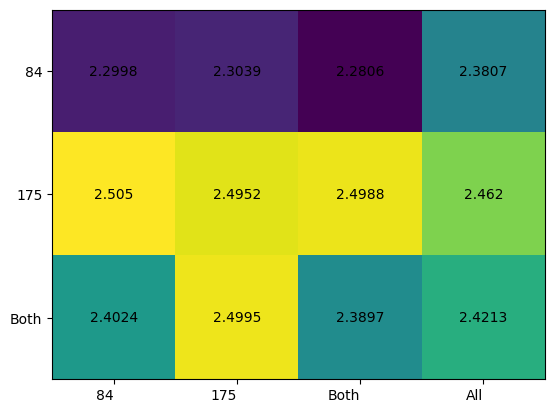

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
columns = ['84', '175', 'Both', 'All']
index = ['84', '175', 'Both']
df = pd.DataFrame([
    [2.2998, 2.3039, 2.2806, 2.3807],
    [2.5050, 2.4952, 2.4988, 2.4620],
    [2.4024, 2.4995, 2.3897, 2.4213],
], columns=columns, index=index)

fig, ax = plt.subplots()
im = ax.imshow(df)
ax.set_xticks(np.arange(len(df.columns)))
ax.set_xticklabels(df.columns)
ax.set_yticks(np.arange(len(df.index)))
ax.set_yticklabels(df.index)


plt.setp(ax.get_xticklabels(), rotation=0, ha="right", rotation_mode="anchor")



for i in range(len(df.columns)):
    for j in range(len(df.index)):
        text = ax.text(i, j, df.iloc[j, i], ha="center", va="center", color="black")
plt.show()